### Environment setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import gc
import sys

sys.path.append('/content/drive/MyDrive/Earthquake_Detection')

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from PIL import Image
from scipy import signal
from scipy.signal import resample, hilbert
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

import earthquake_detection.architectures as architectures
import earthquake_detection.training_utils as training_utils

plt.ioff() # Turn off matplotlib interactive mode. Prevents  memory leakage.

### Load datasets

These datasets were pre-processed from their raw STEAD format using the `DataPreprocessing` module and `data_preprocessing` notebook contained within this repo.

In [ ]:
# Load extracted raw signals
raw_signals = np.load('/content/drive/MyDrive/Earthquake_Detection/DATA1/extracted_raw_signals_subsample_20000.npy')

# Load metadata
metadata = pd.read_feather('/content/drive/MyDrive/Earthquake_Detection/DATA1/extracted_metadata_subsample_20000.feather')
metadata = metadata.reset_index()

In [ ]:
test_signals = raw_signals[:10]
test_meta = metadata.iloc[:10]

#### Inspect data to ensure it looks as expected

In [ ]:
test_signals.shape

(10, 6000, 3)

In [ ]:
test_signals[0][:,2]

array([-133.32683, -290.72406, -508.25934, ..., -201.54117, -141.1144 ,
       -346.19913], dtype=float32)

In [ ]:
test_meta

,trace_name,network_code,receiver_code,receiver_type,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_status,p_weight,...,source_mechanism_strike_dip_rake,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,coda_end_sample,trace_start_time,trace_category,chunk,weight_for_subsample
0,ATH.HL_20141117231337_EV,HL,ATH,HH,37.973840,23.717670,93.0,500.0,manual,0.50,...,None,0.71000,79.01,161.900,[33.70000076 32.09999847 24.5 ],[[5276.]],2014-11-17 23:13:38.480000,earthquake_local,1,0.000033
1,AUQ.AV_20140311230706_EV,AV,AUQ,BH,59.354900,-153.414300,647.0,800.0,manual,1.00,...,None,0.44727,49.65,8.828,[30. 24.5 29.10000038],[[3960.]],2014-03-11 23:07:06.230000,earthquake_local,1,0.000033
2,B081.PB_20110303193132_EV,PB,B081,EH,33.711167,-116.714167,1467.0,700.0,manual,0.23,...,None,0.77320,85.83,12.000,[39.40000153 37. 34.29999924],[[2809.]],2011-03-03 19:31:32.360000,earthquake_local,1,0.000033
3,B086.PB_20140320053737_EV,PB,B086,HH,33.557500,-116.531000,1392.0,601.0,autopicker,0.93,...,None,0.08935,9.94,149.000,[19.10000038 18.20000076 26.29999924],[[1547.]],2014-03-20 05:37:38.030000,earthquake_local,1,0.000033
4,JGR.NC_200405070749_NO,NC,JGR,HN,37.516040,-122.458150,282.0,NaN,None,NaN,...,None,NaN,NaN,NaN,None,None,2004-05-07 07:49:00,noise,1,0.000050
5,B086.PB_20150805031558_EV,PB,B086,HH,33.557500,-116.531000,1392.0,764.0,autopicker,0.82,...,None,0.46040,51.11,343.000,[24.60000038 21.10000038 20.29999924],[[2115.]],2015-08-05 03:15:59.610000,earthquake_local,1,0.000033
6,CMGA.ET_20180115234924_NO,ET,CMGA,EH,34.629000,-85.034000,478.0,NaN,None,NaN,...,None,NaN,NaN,NaN,None,None,2018-01-15 23:49:24,noise,1,0.000050
7,AHUD.HV_20160806181726_EV,HV,AHUD,EH,19.371567,-155.263462,1051.0,800.0,manual,0.65,...,None,0.23870,26.56,228.400,[15. 13.19999981 23.70000076],[[2751.]],2016-08-06 18:17:27.270000,earthquake_local,1,0.000033
8,B058.PB_20180706031153_EV,PB,B058,EH,36.799500,-121.580800,114.2,900.0,manual,0.60,...,None,0.32720,36.38,128.700,[13.80000019 13.60000038 11.5 ],[[2389.]],2018-07-06 03:11:54.450000,earthquake_local,1,0.000033
9,SHP.NN_201309222004_NO,NN,SHP,HH,36.505500,-115.160200,1626.0,NaN,None,NaN,...,None,NaN,NaN,NaN,None,None,2013-09-22 20:04:00,noise,1,0.000050


### Create labels for classification model training

In [ ]:
test_meta['label'] = [1 if label=='earthquake_local' else 0 for label in test_meta['trace_category']]
classifier_labels = test_meta['label'].values

<ipython-input-20-29ff34ff961d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_meta['label'] = [1 if label=='earthquake_local' else 0 for label in test_meta['trace_category']]


### Pre-processing to calculate signal envelopes

In [ ]:
def hilbert_transform_rolling_avg(raw_signal, resampled=True):
    sos = signal.butter(4, (1,49.9), 'bandpass', fs=100, output='sos') # filter signal from 1-50 Hz, 4th order filter
    filtered = signal.sosfilt(sos, raw_signal[:,2]) # use only z-axis signal component
    analytic_signal = hilbert(filtered) # apply hilbert transform to get signal envelope
    amplitude_envelope = np.abs(analytic_signal) # get only positive envelope
    env_series = pd.Series(amplitude_envelope) # convert to a series to be compatible with pd.Series rolling mean calc
    rolling_obj = env_series.rolling(200) # 2-second rolling mean (100 Hz * 2 sec = 200 samples)
    rolling_average = rolling_obj.mean()
    rolling_average_demeaned = rolling_average[199:] - np.mean(rolling_average[199:])
    rolling_average_padded = np.pad(rolling_average_demeaned, (199,0), 'constant', constant_values=(list(rolling_average_demeaned)[0])) # pad to remove nans created by rolling mean
    if resampled:
        return signal.resample(rolling_average_padded, 300) # resample signal from 6000 samples to 300 to reduce size
    else:
        return rolling_average_padded

In [ ]:
# For demonstration/plotting purposes only
signal_envelopes = np.array([hilbert_transform_rolling_avg(raw_signal, resampled=False) for raw_signal in test_signals[0:10]])

In [ ]:
# These are the envelopes that will be used for model training
signal_envelopes_resamp = np.array([hilbert_transform_rolling_avg(raw_signal, resampled=True) for raw_signal in test_signals])

#### Plot an example trace vs. its envelope

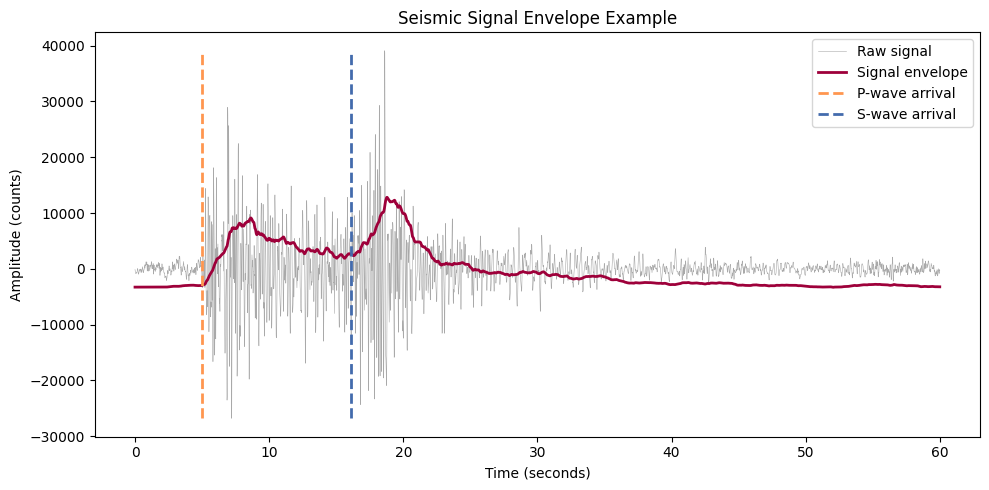

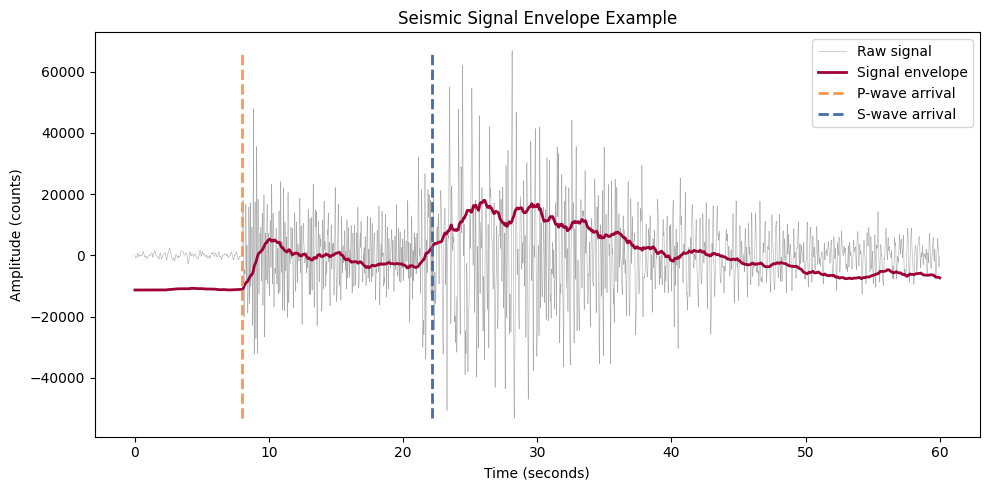

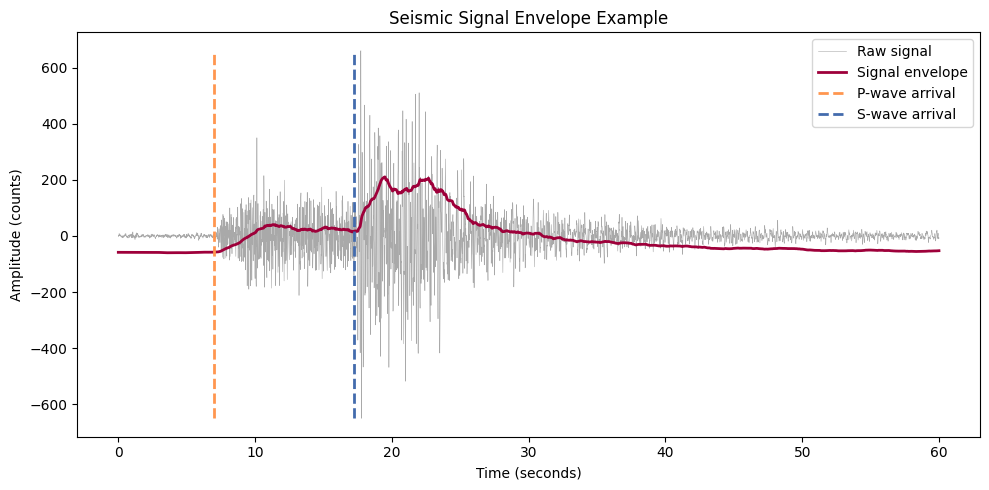

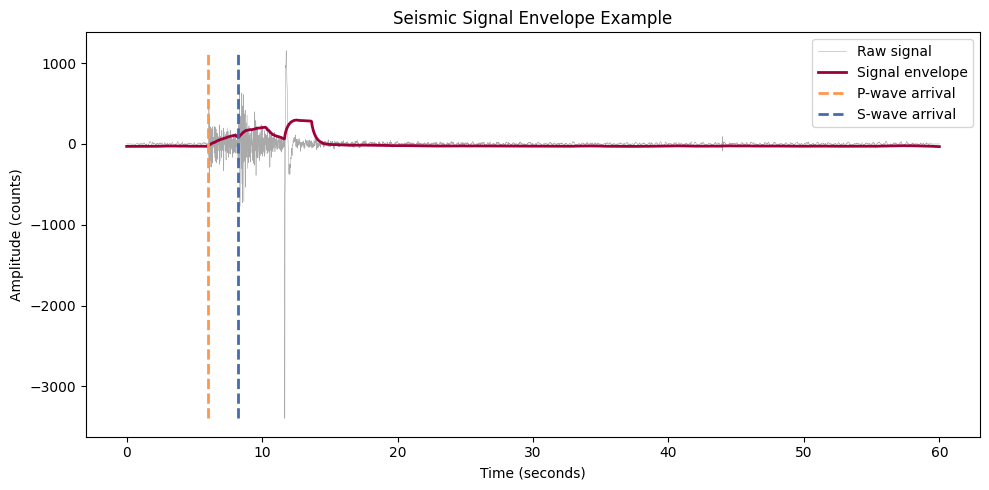

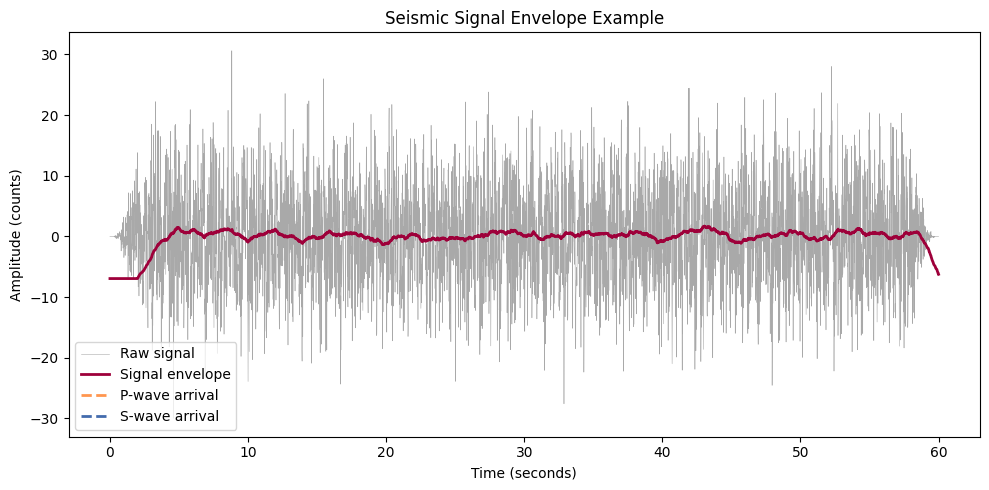

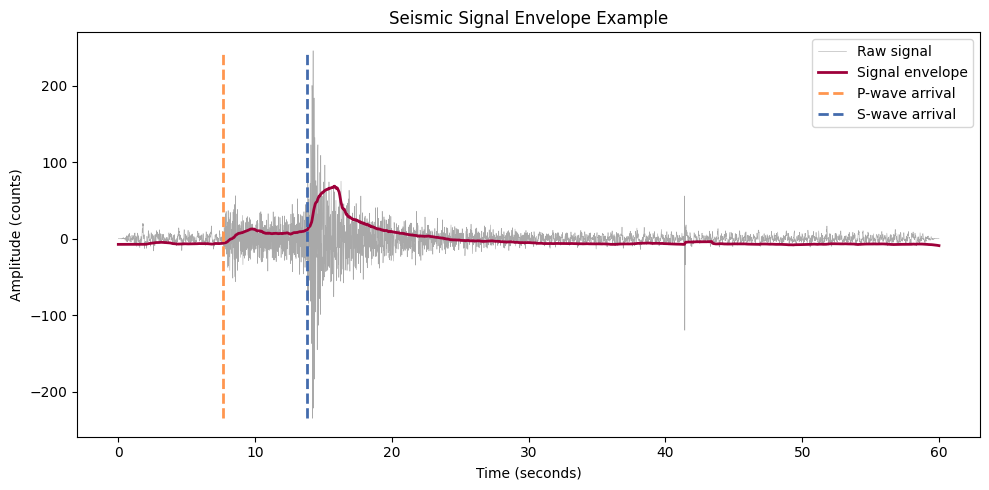

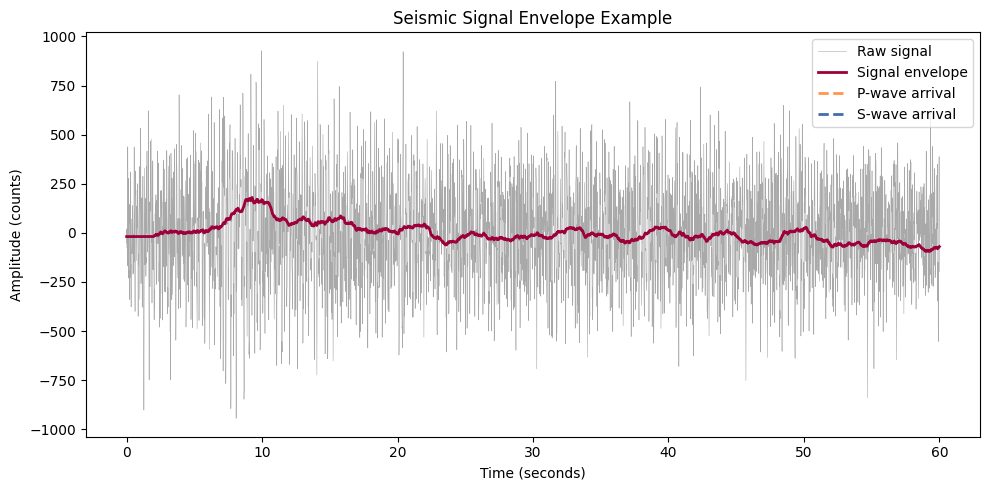

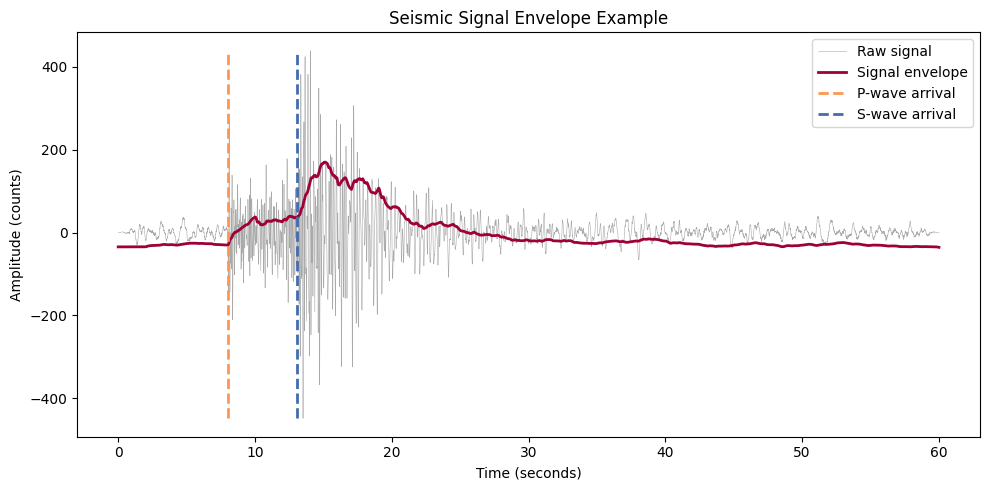

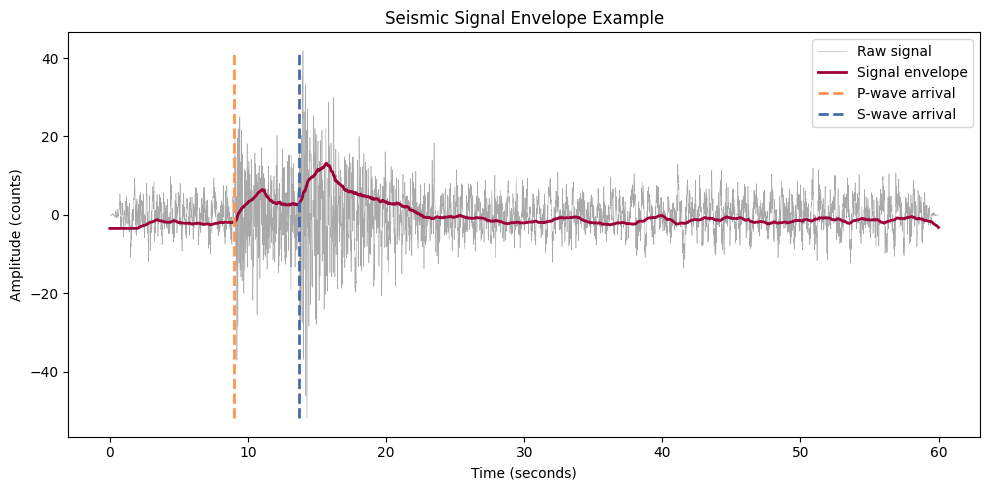

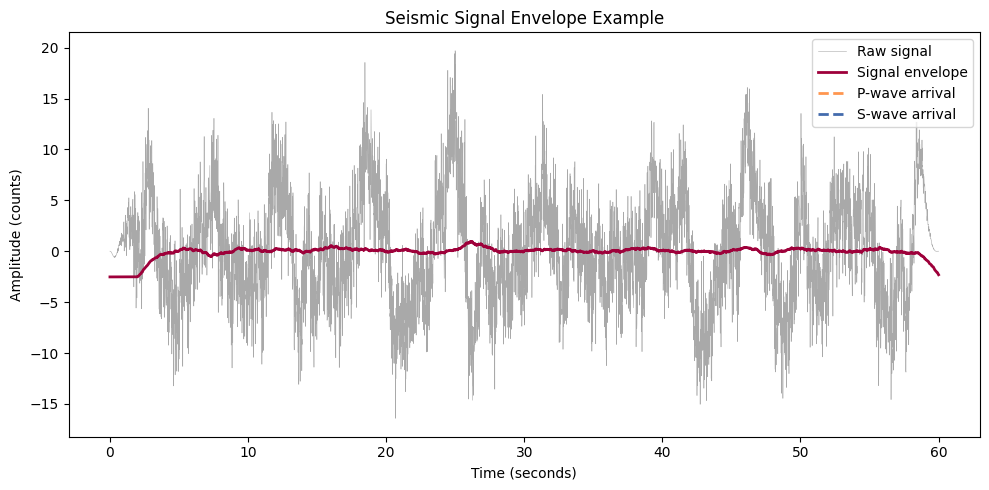

In [ ]:
for i in range(0,10): # example trace
  fig, ax = plt.subplots(1,1,figsize=(10,5))
  sig = raw_signals[i][:,2]
  ax.plot(np.linspace(0,60,6000), sig, color='darkgrey', linewidth=0.4, label='Raw signal')
  ax.plot(np.linspace(0,60,6000), signal_envelopes[i], color='xkcd:cranberry', linewidth=2, label='Signal envelope')
  p_wave = metadata.iloc[i]['p_arrival_sample']
  s_wave = metadata.iloc[i]['s_arrival_sample']
  ax.vlines(p_wave/100.0, sig.min(), sig.max(), color='xkcd:pastel orange', linewidth=2, linestyle='--', label='P-wave arrival')
  ax.vlines(s_wave/100.0, sig.min(), sig.max(), color='xkcd:french blue', linewidth=2, linestyle='--', label='S-wave arrival')
  ax.set_xlabel('Time (seconds)')
  ax.set_ylabel('Amplitude (counts)')
  ax.set_title('Seismic Signal Envelope Example')
  ax.legend()
  plt.tight_layout()
  plt.show()

### Create subsets of earthquake-only data (no noise samples)

In [ ]:
earthquakes_indices = np.array(list(test_meta[test_meta['trace_category']=='earthquake_local'].index))
test_signals_earthquakes_only = test_signals[earthquakes_indices]
envelopes_earthquakes_only = signal_envelopes_resamp[earthquakes_indices]
metadata_earthquakes_only = test_meta[test_meta['trace_category']=='earthquake_local']

### Reshape signal envelopes so they have the correct format for input into the LSTM models

In [ ]:
signal_envelopes_resamp = np.reshape(signal_envelopes_resamp, (signal_envelopes_resamp.shape[0], 1, signal_envelopes_resamp.shape[1]))
envelopes_earthquakes_only = np.reshape(envelopes_earthquakes_only, (envelopes_earthquakes_only.shape[0], 1, envelopes_earthquakes_only.shape[1]))

## Model testing

### 1. Classification LSTM model to predict whether signals are 'earthquake' or 'noise'

In [ ]:
def prepare_datasets(
    imgs, labels, preproc_func=None, preproc_func_kwargs=None,
    use_scaler=False
):
    # If array has only one dimension, it must be reshaped for input into the scaler
    if labels.ndim == 1:
        labels = labels.reshape(-1, 1)

    # Convert to TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((imgs, labels))

    # Apply preprocessing if a function is provided
    if preproc_func:
        dataset = dataset.map(lambda x, y: (preproc_func(x, **preproc_func_kwargs), y))

    return dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


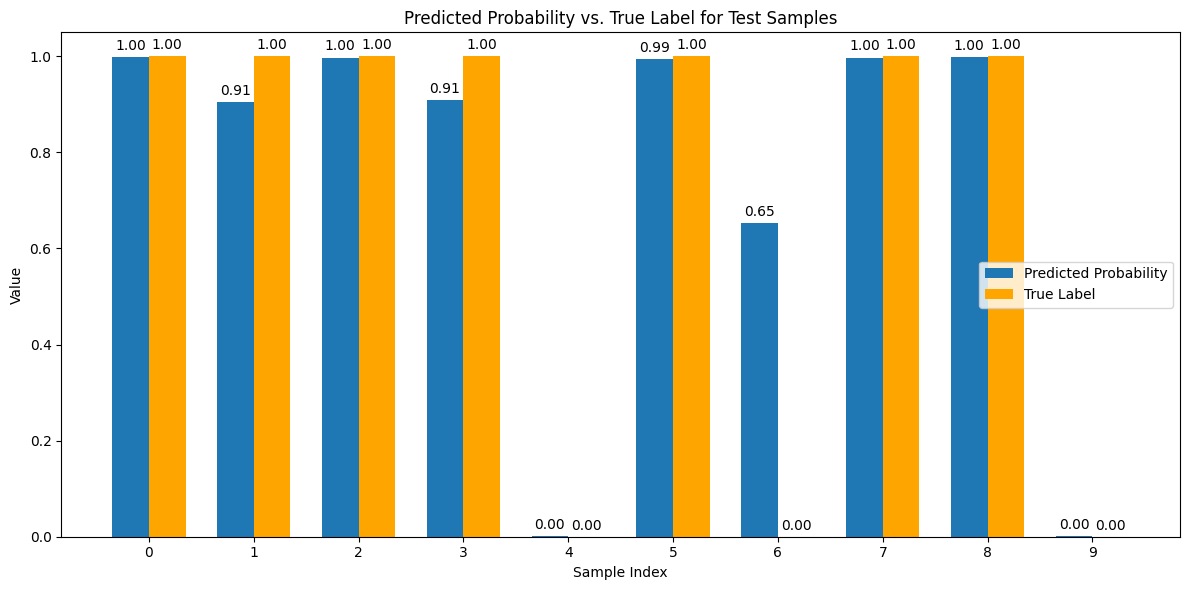

In [ ]:
test_dataset_c = prepare_datasets(imgs=signal_envelopes_resamp, labels=classifier_labels)
# input_shape = (signal_envelopes_resamp.shape[1], signal_envelopes_resamp.shape[2])
test_model = tf.keras.models.load_model('/content/drive/MyDrive/Earthquake_Detection/Model2/lstm_classification_100epochs_1748078961.keras')
predicted_values = test_model.predict(test_dataset_c.batch(10)).flatten() # Batch the dataset for prediction

## PLOTS
# Get the true labels
true_labels = classifier_labels

# Create an array of sample indices
sample_indices = np.arange(len(true_labels))

# Set the width of the bars
bar_width = 0.35

# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the predicted values
rects1 = ax.bar(sample_indices - bar_width/2, predicted_values, bar_width, label='Predicted Probability')

# Plot the true labels
rects2 = ax.bar(sample_indices + bar_width/2, true_labels, bar_width, label='True Label', color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Sample Index')
ax.set_ylabel('Value')
ax.set_title('Predicted Probability vs. True Label for Test Samples')
ax.set_xticks(sample_indices)
ax.set_xticklabels(sample_indices)
ax.legend()

# Add value labels on top of the bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2., height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


plt.tight_layout()
plt.show()

### 2. Regression LSTM model for earthquake magnitude prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


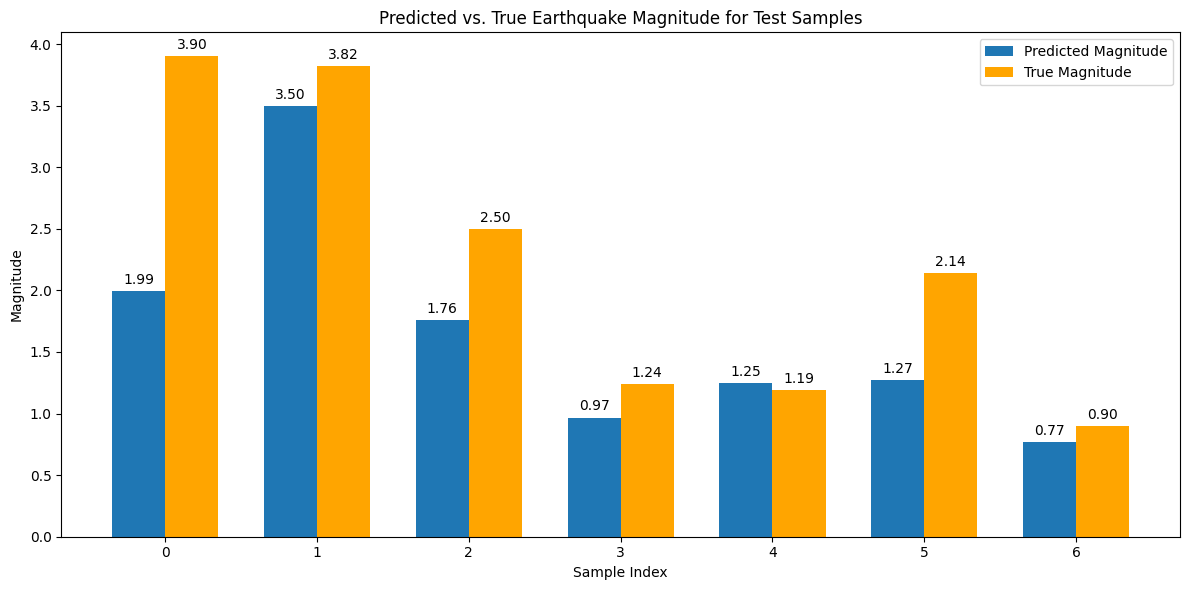

In [ ]:
labels = np.array(metadata_earthquakes_only['source_magnitude'])
test_dataset_mag = prepare_datasets(imgs=envelopes_earthquakes_only, labels=labels)
test_model = tf.keras.models.load_model('/content/drive/MyDrive/Earthquake_Detection/Model2/lstm_regression_magnitude_100epochs_1748079447.keras')
predicted_values = test_model.predict(test_dataset_mag.batch(len(labels))).flatten()

# Get the true magnitude labels
true_magnitudes = np.array(metadata_earthquakes_only['source_magnitude'])

# Create an array of sample indices
sample_indices_mag = np.arange(len(true_magnitudes))

# Set the width of the bars
bar_width_mag = 0.35

# Create the bar chart
fig_mag, ax_mag = plt.subplots(figsize=(12, 6))

# Plot the predicted magnitudes
rects_pred_mag = ax_mag.bar(sample_indices_mag - bar_width_mag/2, predicted_values, bar_width_mag, label='Predicted Magnitude')

# Plot the true magnitudes
rects_true_mag = ax_mag.bar(sample_indices_mag + bar_width_mag/2, true_magnitudes, bar_width_mag, label='True Magnitude', color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax_mag.set_xlabel('Sample Index')
ax_mag.set_ylabel('Magnitude')
ax_mag.set_title('Predicted vs. True Earthquake Magnitude for Test Samples')
ax_mag.set_xticks(sample_indices_mag)
ax_mag.set_xticklabels(sample_indices_mag)
ax_mag.legend()

# Add value labels on top of the bars
def autolabel_mag(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax_mag.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2., height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel_mag(rects_pred_mag)
autolabel_mag(rects_true_mag)

plt.tight_layout()
plt.show()

### 3. Regression LSTM model training & evaluation for earthquake p-wave arrival time prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


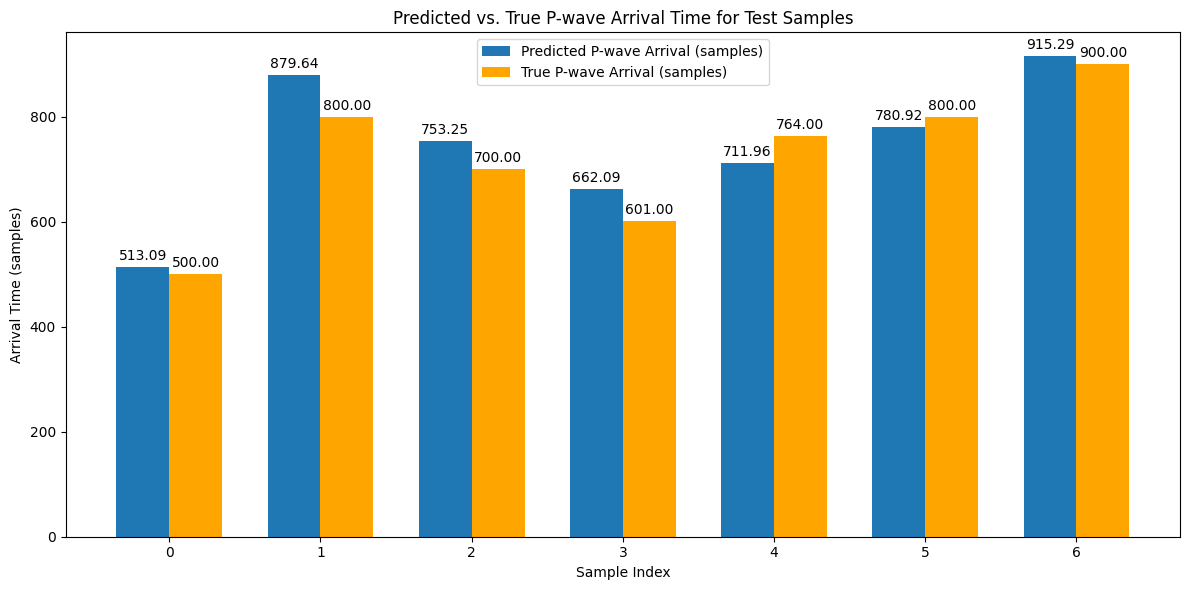

In [ ]:
labels = np.array(metadata_earthquakes_only['p_arrival_sample'])
test_dataset_pwave = prepare_datasets(imgs=envelopes_earthquakes_only, labels=labels)
test_model = tf.keras.models.load_model('/content/drive/MyDrive/Earthquake_Detection/Model2/lstm_regression_pwave_100epochs_1748079884.keras')
predicted_values = test_model.predict(test_dataset_pwave.batch(len(labels))).flatten()

# Get the true magnitude labels
true_pwave = np.array(metadata_earthquakes_only['p_arrival_sample'])

# Create an array of sample indices
sample_indices_pwave = np.arange(len(true_pwave))

# Set the width of the bars
bar_width_pwave = 0.35

# Create the bar chart
fig_pwave, ax_pwave = plt.subplots(figsize=(12, 6))

# Plot the predicted P-wave arrival times
rects_pred_pwave = ax_pwave.bar(sample_indices_pwave - bar_width_pwave/2, predicted_values, bar_width_pwave, label='Predicted P-wave Arrival (samples)')

# Plot the true P-wave arrival times
rects_true_pwave = ax_pwave.bar(sample_indices_pwave + bar_width_pwave/2, true_pwave, bar_width_pwave, label='True P-wave Arrival (samples)', color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax_pwave.set_xlabel('Sample Index')
ax_pwave.set_ylabel('Arrival Time (samples)')
ax_pwave.set_title('Predicted vs. True P-wave Arrival Time for Test Samples')
ax_pwave.set_xticks(sample_indices_pwave)
ax_pwave.set_xticklabels(sample_indices_pwave)
ax_pwave.legend()

# Add value labels on top of the bars
def autolabel_pwave(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax_pwave.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2., height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel_pwave(rects_pred_pwave)
autolabel_pwave(rects_true_pwave)

plt.tight_layout()
plt.show()

### 4. Regression LSTM model training & evaluation for earthquake s-wave arrival time prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


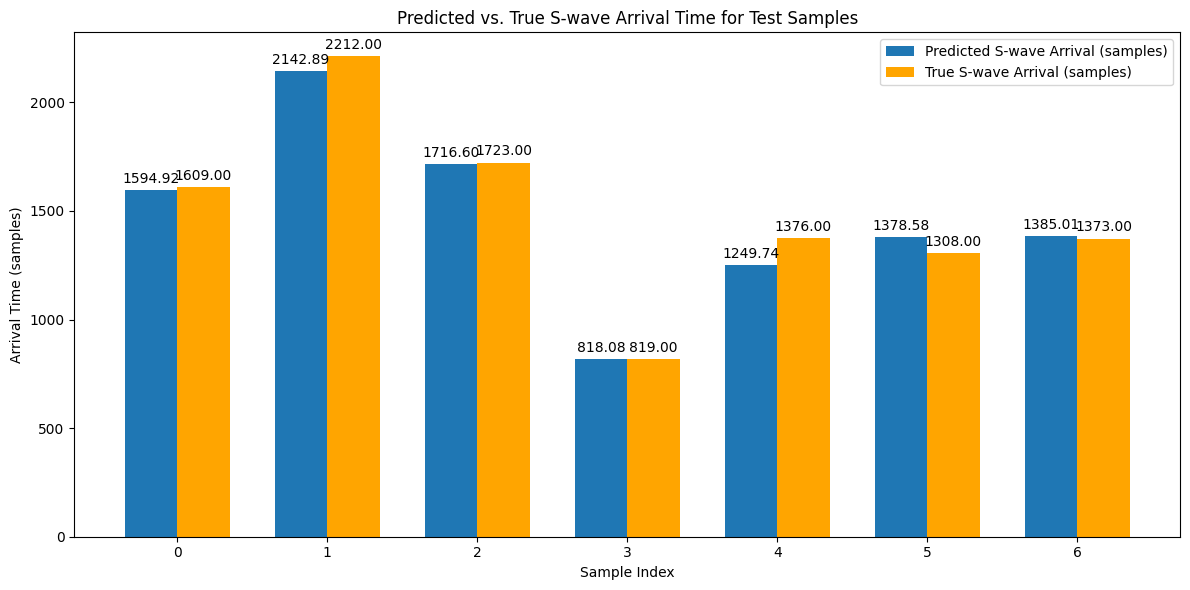

In [ ]:
labels = np.array(metadata_earthquakes_only['s_arrival_sample'])
test_dataset_swave = prepare_datasets(imgs=envelopes_earthquakes_only, labels=labels)
test_model = tf.keras.models.load_model('/content/drive/MyDrive/Earthquake_Detection/Model2/lstm_regression_swave_100epochs_1748080052.keras')
predicted_values = test_model.predict(test_dataset_swave.batch(len(labels))).flatten()

# Get the true S-wave arrival times
true_swave = np.array(metadata_earthquakes_only['s_arrival_sample'])

# Create an array of sample indices
sample_indices_swave = np.arange(len(true_swave))

# Set the width of the bars
bar_width_swave = 0.35

# Create the bar chart
fig_swave, ax_swave = plt.subplots(figsize=(12, 6))

# Plot the predicted S-wave arrival times
rects_pred_swave = ax_swave.bar(sample_indices_swave - bar_width_swave/2, predicted_values, bar_width_swave, label='Predicted S-wave Arrival (samples)')

# Plot the true S-wave arrival times
rects_true_swave = ax_swave.bar(sample_indices_swave + bar_width_swave/2, true_swave, bar_width_swave, label='True S-wave Arrival (samples)', color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax_swave.set_xlabel('Sample Index')
ax_swave.set_ylabel('Arrival Time (samples)')
ax_swave.set_title('Predicted vs. True S-wave Arrival Time for Test Samples')
ax_swave.set_xticks(sample_indices_swave)
ax_swave.set_xticklabels(sample_indices_swave)
ax_swave.legend()

# Add value labels on top of the bars
def autolabel_swave(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax_swave.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2., height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel_swave(rects_pred_swave)
autolabel_swave(rects_true_swave)

plt.tight_layout()
plt.show()